In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import json
import jsonlines
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import requests
import base64
import pickle
import torch

from FlagEmbedding import BGEM3FlagModel
from collections import defaultdict

In [2]:
# Read raw data
test_data_dict = {}
docs_data_dict = {}
for path in glob('./annotated_data/*.json'):
    dset = pd.read_json(path)
    dset_name = path.split('/')[-1].replace('.json', '')
    test_data_dict[dset_name] = dset
    print(f"Loading `{dset_name}` with {len(dset)} data points.")

    # Read context documents
    docs_data = []
    for path in glob(f'./repairbench_docs/{dset_name}_docs/*'):
        json_data = json.load(open(path, 'r'))
        for i in range(len(json_data)):
            json_data[i]['metadata']['chunk_idx'] = i+1
        docs_data += json_data

    docs_data_dict[dset_name] = docs_data
    print(f'Loaded {len(docs_data)} document chunks for `{dset_name}`')
    print()

Loading `repairbench_ko` with 55 data points.
Loaded 162 document chunks for `repairbench_ko`

Loading `repairbench_en` with 373 data points.
Loaded 2224 document chunks for `repairbench_en`

Loading `repairbench_ja` with 222 data points.
Loaded 1429 document chunks for `repairbench_ja`



# Retrieval Evaluation BGE-M3

In [3]:
model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=False, device="cuda:0")

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
# Build Index
docs_embed_dict = {}
for dset_name, docs_data in docs_data_dict.items():
    if os.path.exists(f'./{dset_name}_docs_bge_m3_embed.pkl'):
        print(f'Loading `{dset_name}` docs embed from cache...')
        docs_embed_dict[dset_name] = pickle.load(open(f'./{dset_name}_docs_bge_m3_embed.pkl', 'rb'))
    else:
        print(f'Running document embed for `{dset_name}`')
        texts = list(map(lambda x: x['text'], docs_data))
        docs_embeds = model.encode(texts, batch_size=64, max_length=8192)['dense_vecs']        
        pickle.dump(docs_embeds, open(f'{dset_name}_docs_bge_m3_embed.pkl', 'wb'))
        docs_embed_dict[dset_name] = docs_embeds

Loading `repairbench_ko` docs embed from cache...
Loading `repairbench_en` docs embed from cache...
Loading `repairbench_ja` docs embed from cache...


In [6]:
query_embed_dict = {}
for dset_name, test_df in test_data_dict.items():
    # Embed all queries
    if os.path.exists(f'{dset_name}_query_bge_m3_embed.pkl'):
        print(f'Loading `{dset_name}` query embed from cache...')
        query_embeds = pickle.load(open(f'{dset_name}_query_bge_m3_embed.pkl', 'rb'))
    else:
        print(f'Running query embed for `{dset_name}`')
        texts = test_df.apply(lambda x: x['data']['question'], axis='columns').tolist()
        query_embeds = model.encode(texts, batch_size=8, max_length=8192)['dense_vecs']

        pickle.dump(query_embeds, open(f'{dset_name}_query_bge_m3_embed.pkl', 'wb'))
    query_embed_dict[dset_name] = query_embeds

Loading `repairbench_ko` query embed from cache...
Loading `repairbench_en` query embed from cache...
Loading `repairbench_ja` query embed from cache...


In [7]:
# Retrieval Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>
# docs_data_dict: Dict<dataset_name, List<document_chunk>>
# docs_embed_dict: Dict<dataset_name, Tensor[n_docs, n_dim] >
# query_embed_dict: Dict<dataset_name, Tensor[n_queries, n_dim]>

ks = np.arange(5, 150, 5)
eval_dict = {}
for dset_name, test_df in test_data_dict.items():
    docs_uids = list(map(lambda x: f"{x['metadata']['filename']}_{x['metadata']['chunk_idx']}", docs_data_dict[dset_name]))
    silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
    gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
    
    docs_embed = torch.from_numpy(docs_embed_dict[dset_name])
    query_embed = torch.from_numpy(query_embed_dict[dset_name])
    docs_indices = (query_embed @ docs_embed.T).topk(max(ks), dim=-1).indices

    metrics = {}
    for k in ks:
        k_metrics = defaultdict(lambda: 0)
        for silver_uids, gold_uids, docs_idx in zip(silver_uids_list, gold_uids_list, docs_indices):
            if len(silver_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'any_silver_correct'] += 1 if len(set(pred_uids).intersection(set(silver_uids))) > 0 else 0
                k_metrics[f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                k_metrics[f'silver_count'] += len(set(silver_uids))
                k_metrics[f'silver_row_count'] += 1
            if len(gold_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'any_gold_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                k_metrics[f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                k_metrics[f'gold_count'] += len(set(gold_uids))
                k_metrics[f'gold_row_count'] += 1
        metrics[k] = {
            # 'silver_acc': k_metrics[f'silver_correct'] / k_metrics[f'silver_count'], 
            'gold_acc': k_metrics[f'gold_correct'] / k_metrics[f'gold_count'],
            # 'any_silver_acc': k_metrics[f'any_silver_correct'] / k_metrics[f'silver_row_count'], 
            'any_gold_acc': k_metrics[f'any_gold_correct'] / k_metrics[f'gold_row_count'],
        }
    eval_dict[dset_name] = dict(metrics)

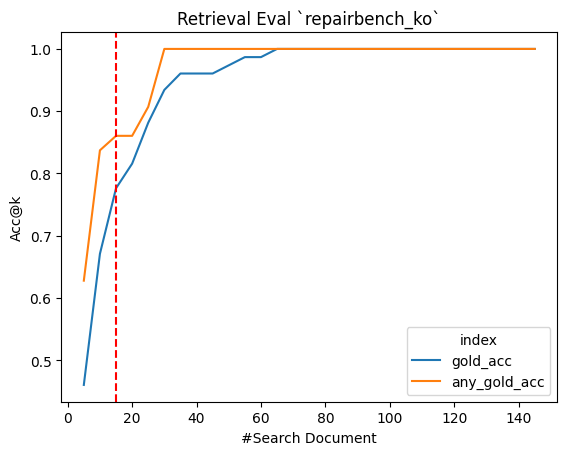

In [8]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

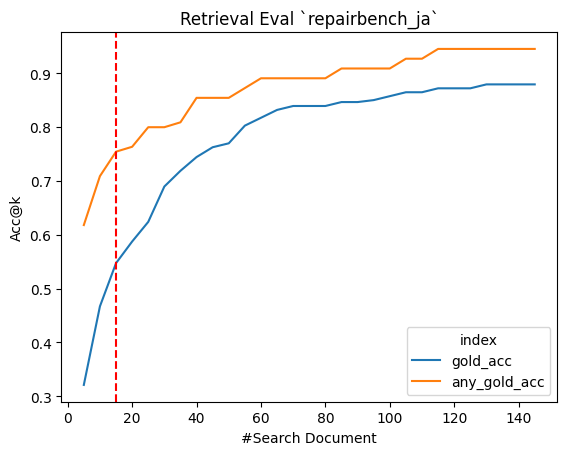

In [9]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

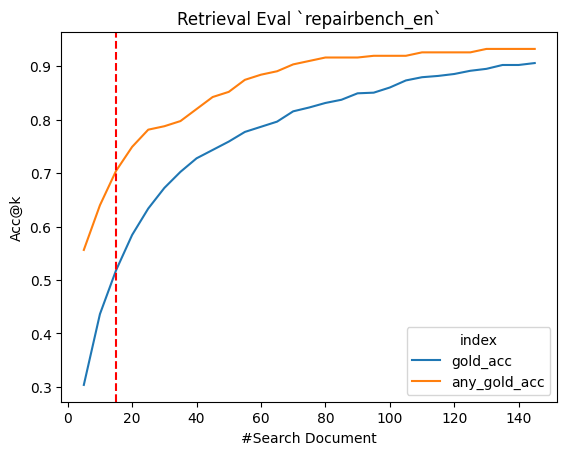

In [10]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

# Retrieval Evaluation E5-Large Instruct

In [11]:
from sentence_transformers import SentenceTransformer

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

task = 'Given a web search query, retrieve relevant passages that answer the query'
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device='cuda:0')

In [12]:
# Build Index
docs_embed_dict = {}
for dset_name, docs_data in docs_data_dict.items():
    if os.path.exists(f'./{dset_name}_e5_large_instruct_docs_embed.pkl'):
        print(f'Loading `{dset_name}` docs embed from cache...')
        docs_embed_dict[dset_name] = pickle.load(open(f'./{dset_name}_e5_large_instruct_docs_embed.pkl', 'rb'))
    else:
        print(f'Running document embed for `{dset_name}`')
        texts = list(map(lambda x: get_detailed_instruct(task, x['text']), docs_data))
        docs_embeds = model.encode(texts, batch_size=64, convert_to_tensor=True, normalize_embeddings=True)
        pickle.dump(docs_embeds, open(f'./{dset_name}_e5_large_instruct_docs_embed.pkl', 'wb'))
        
        docs_embed_dict[dset_name] = docs_embeds

Loading `repairbench_ko` docs embed from cache...
Loading `repairbench_en` docs embed from cache...
Loading `repairbench_ja` docs embed from cache...


In [13]:
query_embed_dict = {}
for dset_name, test_df in test_data_dict.items():
    # Embed all queries
    if os.path.exists(f'{dset_name}_e5_large_instruct_query_embed.pkl'):
        print(f'Loading `{dset_name}` query embed from cache...')
        query_embeds = pickle.load(open(f'{dset_name}_e5_large_instruct_query_embed.pkl', 'rb'))
    else:
        print(f'Running query embed for `{dset_name}`')
        texts = test_df.apply(lambda x: get_detailed_instruct(task, x['data']['question']), axis='columns').tolist()
        query_embeds = model.encode(texts, batch_size=64, convert_to_tensor=True, normalize_embeddings=True)
        pickle.dump(query_embeds, open(f'{dset_name}_e5_large_instruct_query_embed.pkl', 'wb'))
    query_embed_dict[dset_name] = query_embeds

Loading `repairbench_ko` query embed from cache...
Loading `repairbench_en` query embed from cache...
Loading `repairbench_ja` query embed from cache...


In [14]:
# Retrieval Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>
# docs_data_dict: Dict<dataset_name, List<document_chunk>>
# docs_embed_dict: Dict<dataset_name, Tensor[n_docs, n_dim] >
# query_embed_dict: Dict<dataset_name, Tensor[n_queries, n_dim]>

ks = np.arange(5, 150, 5)
eval_dict = {}
for dset_name, test_df in test_data_dict.items():
    docs_uids = list(map(lambda x: f"{x['metadata']['filename']}_{x['metadata']['chunk_idx']}", docs_data_dict[dset_name]))
    silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
    gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
    
    docs_embed = docs_embed_dict[dset_name]
    query_embed = query_embed_dict[dset_name]
    docs_indices = (query_embed @ docs_embed.T).topk(max(ks), dim=-1).indices

    metrics = {}
    for k in ks:
        k_metrics = defaultdict(lambda: 0)
        for silver_uids, gold_uids, docs_idx in zip(silver_uids_list, gold_uids_list, docs_indices):
            if len(silver_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'any_silver_correct'] += 1 if len(set(pred_uids).intersection(set(silver_uids))) > 0 else 0
                k_metrics[f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                k_metrics[f'silver_count'] += len(set(silver_uids))
                k_metrics[f'silver_row_count'] += 1
            if len(gold_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'any_gold_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                k_metrics[f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                k_metrics[f'gold_count'] += len(set(gold_uids))
                k_metrics[f'gold_row_count'] += 1
        metrics[k] = {
            # 'silver_acc': k_metrics[f'silver_correct'] / k_metrics[f'silver_count'], 
            'gold_acc': k_metrics[f'gold_correct'] / k_metrics[f'gold_count'],
            # 'any_silver_acc': k_metrics[f'any_silver_correct'] / k_metrics[f'silver_row_count'], 
            'any_gold_acc': k_metrics[f'any_gold_correct'] / k_metrics[f'gold_row_count'],
        }
    eval_dict[dset_name] = dict(metrics)

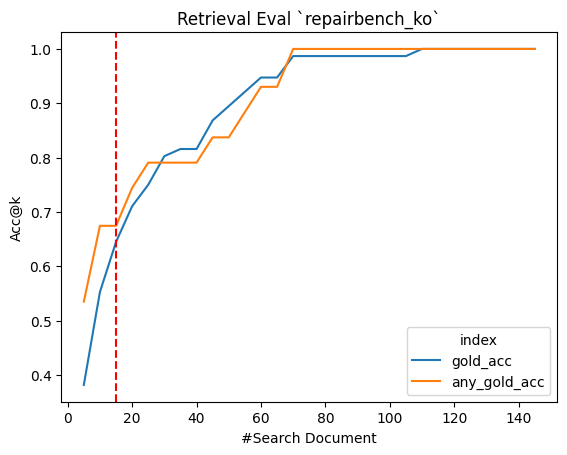

In [15]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

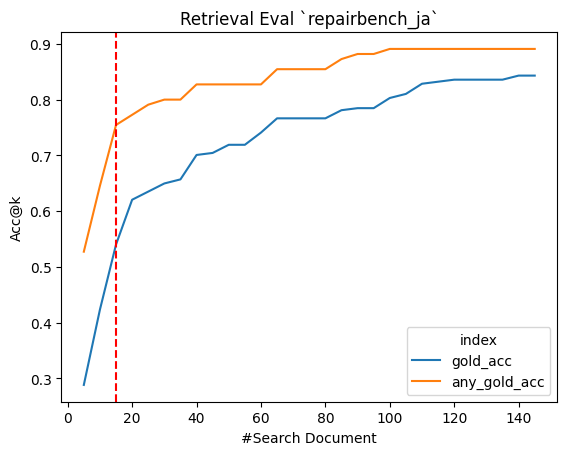

In [16]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

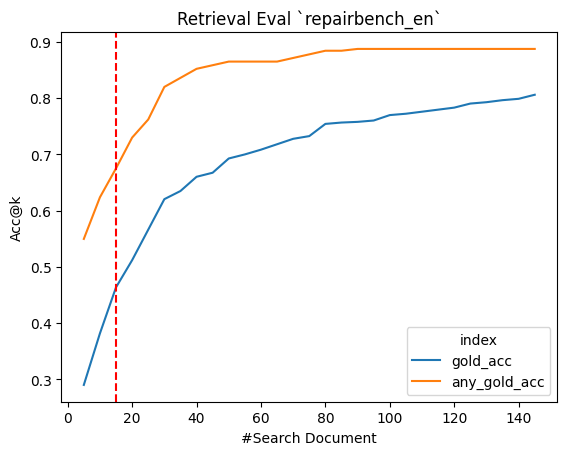

In [17]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()